In [1]:
import os
import fiona
import matplotlib

# matplotlib.use('nbagg')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pyproj import Transformer
from shapely.geometry import Point, Polygon

plt.rcParams["font.family"] = "Times New Roman"

In [2]:
geodir = os.path.join('..', 'data', 'geometry')

In [3]:
preds = gpd.read_file(os.path.join(geodir, 'predictions.geojson'))
preds = preds.sort_values(by=['timestamp'])

In [4]:
xs = preds.geometry.apply(lambda point: point.x).to_numpy()
ys = preds.geometry.apply(lambda point: point.y).to_numpy()

currs = np.stack((xs, ys), axis=1)
nexts = np.stack((xs, ys), axis=1)[1:]
nexts = np.vstack((nexts, np.zeros(2)))

print(currs.shape)
print(nexts.shape)

(10984, 2)
(10984, 2)


In [5]:
t = Transformer.from_crs(crs_from="epsg:28992", crs_to="epsg:4326", always_xy=True)

voetpad = gpd.read_file(os.path.join(geodir, 'bgt_voetpad.gpkg'))
voetpad.geometry = voetpad.geometry.apply(lambda x: Polygon([t.transform(*coord) for coord in x.exterior.coords]))

f = fiona.open(os.path.join('..', 'data', 'amsterdam-pdok', 'bgt_waterdeel.gml'))
df = {'geometry':[]}

for feature in f:
    if feature['geometry']['type'] == 'Polygon':
        coords = feature['geometry']['coordinates'][0]
        coords = [t.transform(*coord) for coord in coords]
        df['geometry'].append(Polygon(coords))

water = gpd.GeoDataFrame(df)

In [6]:
print(preds.height_l.value_counts())
print(preds.height_r.value_counts())

0.00      6598
32.60       10
37.80        9
28.00        9
29.55        9
          ... 
177.55       1
234.20       1
136.30       1
67.90        1
340.80       1
Name: height_l, Length: 2299, dtype: int64
0.00      5979
30.20       11
14.85        9
30.95        8
31.45        8
          ... 
26.05        1
142.00       1
75.50        1
135.70       1
96.85        1
Name: height_r, Length: 2712, dtype: int64


9389


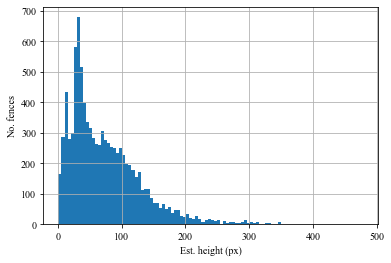

(10211     (37.95, 87.883]
10183     (37.95, 87.883]
10151     (37.95, 87.883]
10008     (37.95, 87.883]
9981      (37.95, 87.883]
               ...       
6717      (37.95, 87.883]
6638     (87.883, 477.85]
6496      (37.95, 87.883]
6307     (87.883, 477.85]
6253     (87.883, 477.85]
Length: 9389, dtype: category
Categories (3, interval[float64, right]): [(0.949, 37.95] < (37.95, 87.883] < (87.883, 477.85]], array([  0.95      ,  37.95      ,  87.88333333, 477.85      ]))
0    6601
1    1592
2    1551
3    1240
Name: class_l, dtype: int64
0    5979
3    1889
2    1582
1    1534
Name: class_r, dtype: int64


In [7]:
heights = preds.height_l.append(preds.height_r)
heights[heights <= 0] = np.nan
heights = heights.dropna()
print(len(heights))

heights.hist(bins=100)

plt.ylabel('No. fences')
plt.xlabel('Est. height (px)')

plt.savefig('hist.pdf') 
plt.show()

bins = pd.qcut(heights, q=3, retbins=True)
print(bins)

def binner(x):
    if bins[1][0] <= x < bins[1][1]:
        return 1
    elif bins[1][1] <= x < bins[1][2]:
        return 2
    elif bins[1][2] <= x < bins[1][3]:
        return 3
    else:
        return 0

preds['class_l'] = preds.height_l.apply(binner)
preds['class_r'] = preds.height_r.apply(binner)

print(preds.class_l.value_counts())
print(preds.class_r.value_counts())

In [8]:
def cmap(c):
    if c == 0:
        return 'red'
    elif c == 1:
        return 'yellow'
    elif c == 2:
        return 'greenyellow'
    elif c == 3:
        return 'green'

cl = [cmap(c) for c in preds.class_l]
cr = [cmap(c) for c in preds.class_r]

In [9]:
SIZE = 5
U_SCALE = 150

a, b = nexts, currs
diffs = (a - b) / np.linalg.norm(a - b)

u_l = np.stack((-diffs[:, 1], diffs[:, 0]), axis=1)
u_r = np.stack((diffs[:, 1], -diffs[:, 0]), axis=1)

preds['dirx'] = diffs[:,0]
preds['diry'] = diffs[:,1]

preds['ulx'] = u_l[:,0]
preds['uly'] = u_l[:,1]

preds['urx'] = u_r[:,0]
preds['ury'] = u_r[:,1]

preds.to_file(os.path.join(geodir, 'predictions_with_u.geojson'), driver='GeoJSON') 

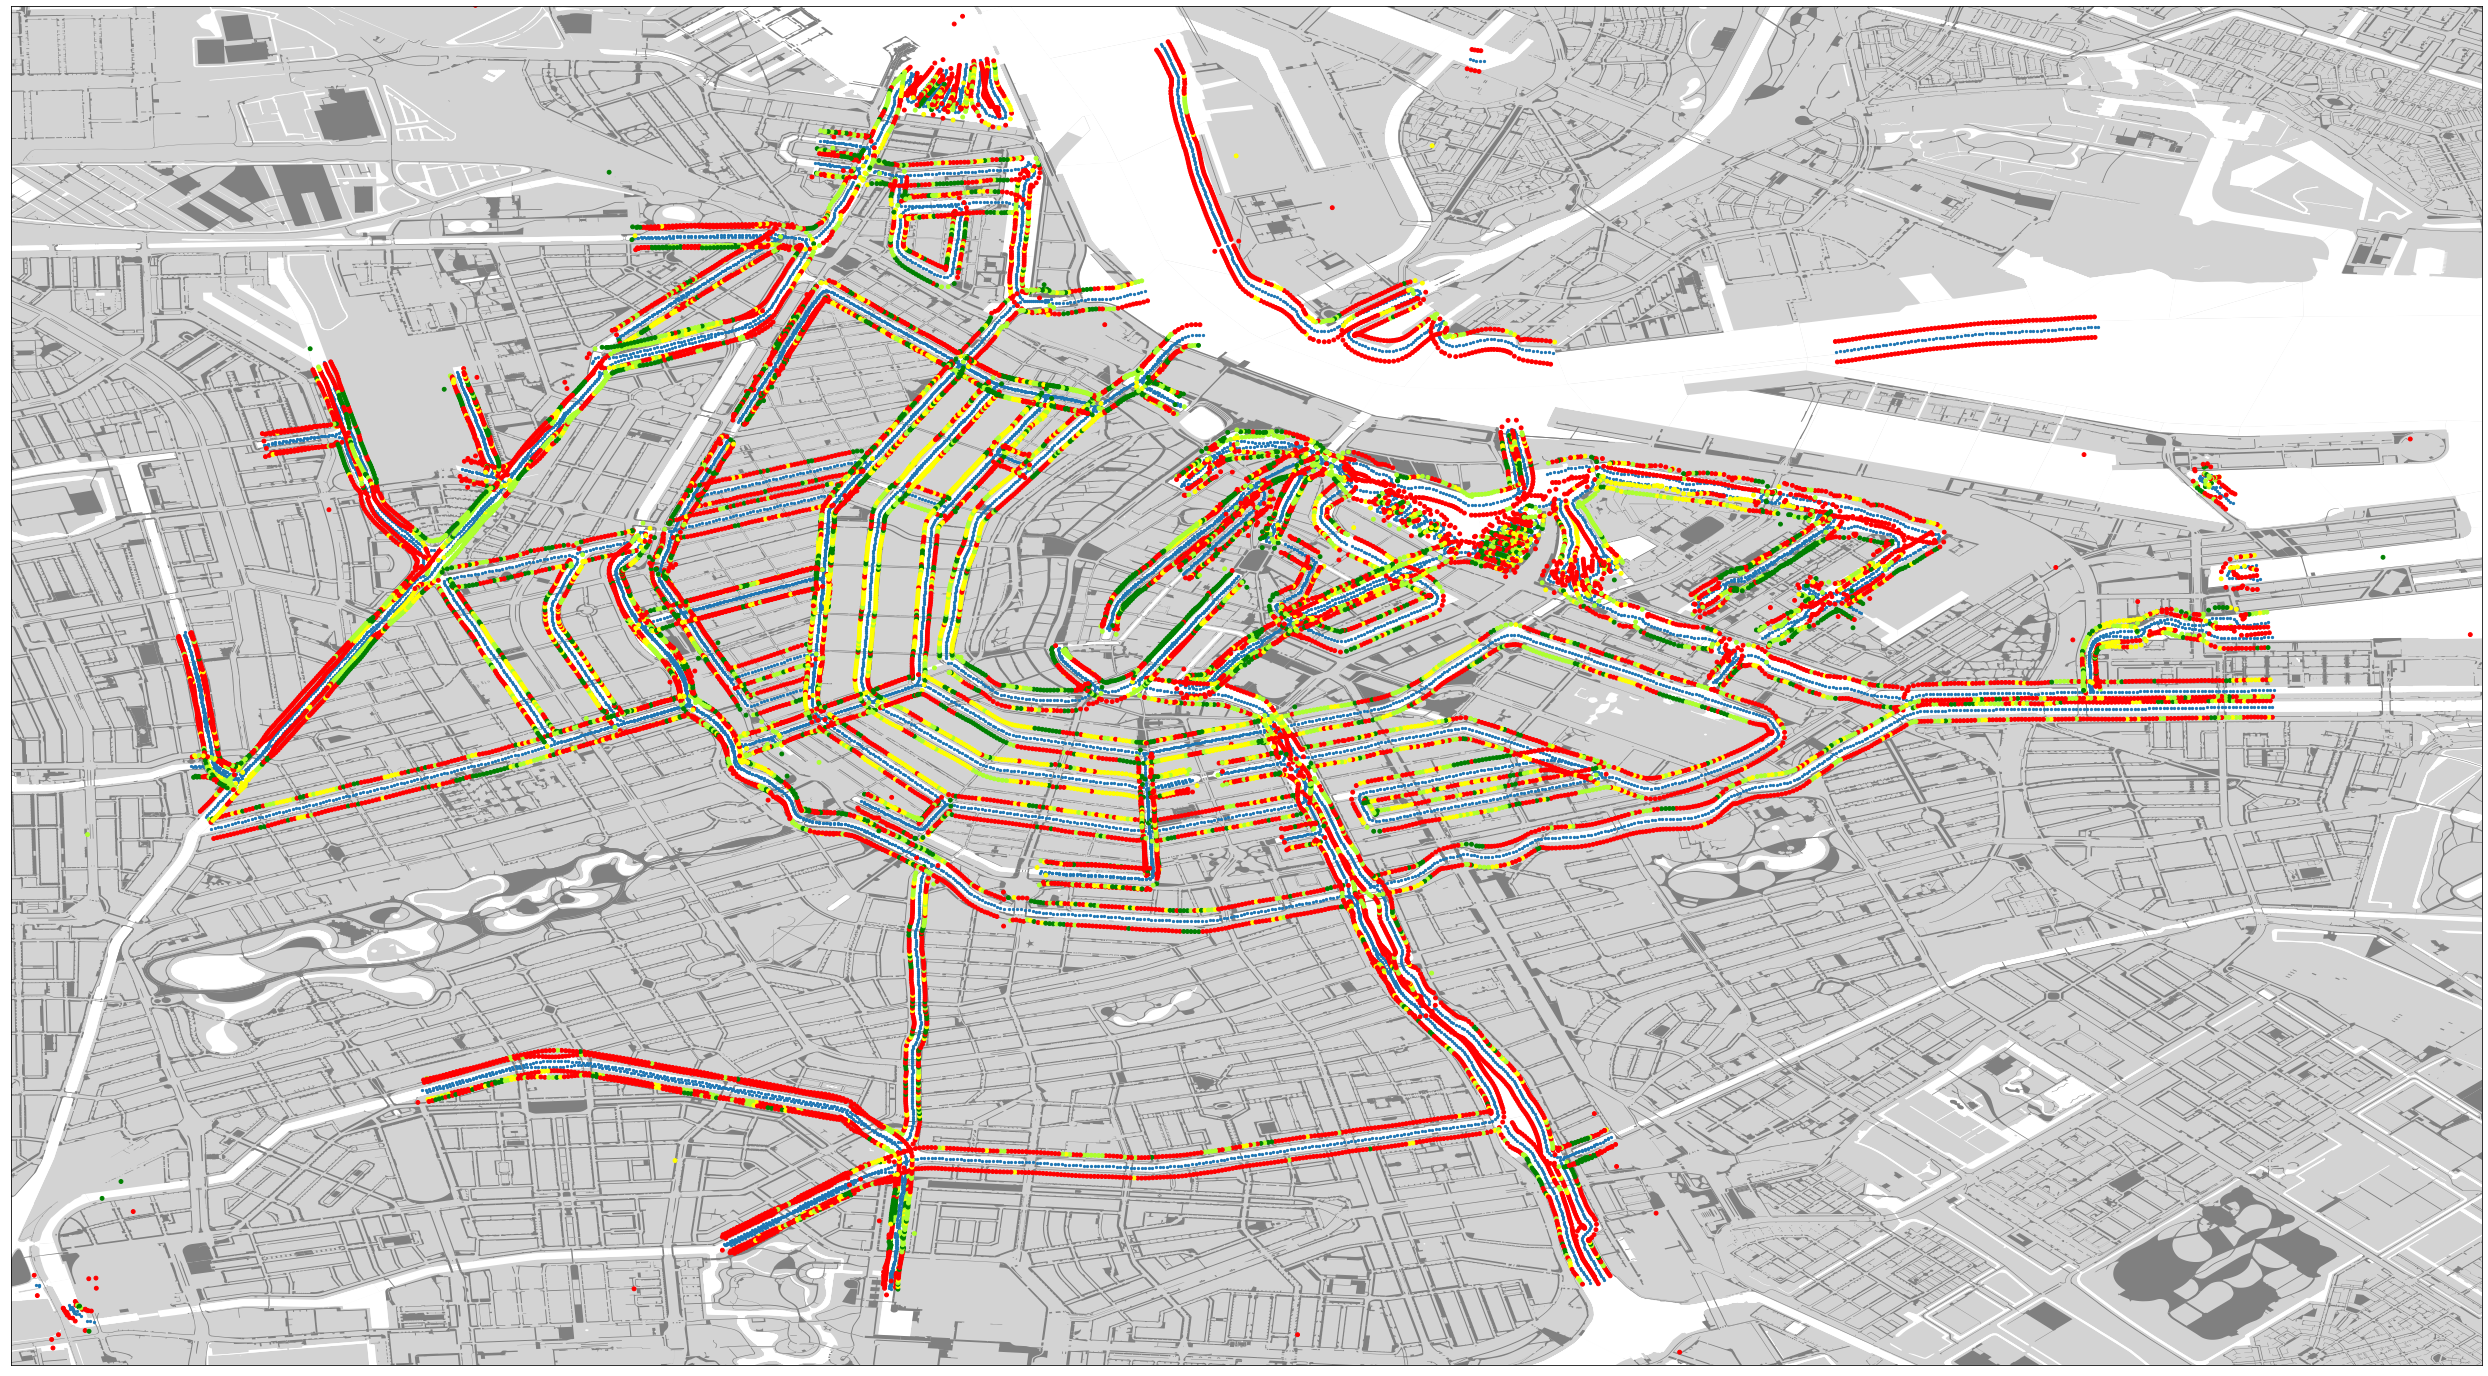

In [10]:
plt.rcParams["figure.figsize"] = (50, 25)

ax = water.plot(color='white')
voetpad.plot(ax=ax, color='grey')

ax.scatter(xs, ys, s=SIZE)
ax.scatter(xs + u_l[:, 0]*U_SCALE, ys + u_l[:, 1]*U_SCALE, color=cl, s=SIZE*3)
ax.scatter(xs + u_r[:, 0]*U_SCALE, ys + u_r[:, 1]*U_SCALE, color=cr, s=SIZE*3)

plt.xlim(4.85, 4.95)
plt.ylim(52.34, 52.395)

ax.set_aspect('equal', adjustable='box')
ax.set_facecolor('lightgrey')

ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

plt.show()